### EXP: kappa and dice consensus

In [1]:
import os
import pandas as pd
import numpy as np
import json
import itertools
import seaborn as sns
from sklearn import metrics
from matplotlib import gridspec as gs
import matplotlib.pyplot as plt
from functools import reduce

In [2]:
%matplotlib inline
%load_ext rpy2.ipython
sns.set(style="white")

In [3]:
def CustomParser(data):
    j1 = json.loads(data)
    return j1

In [4]:
# Read ratings 
Eraters_df = pd.read_csv('../data/rating/all_experts_ratings.csv')
Zraters_df =  pd.read_csv('../data/rating/full_launch_zooniverse_raters_included.csv')

In [5]:
# Randomly split Expert raters in three groups nd zooniverse in 2 groups
import re
import random
random.seed(0)

# match only raters names
Er = re.compile("R.*")
Zr = re.compile("S.*")
Elist = list(filter(Er.match,Eraters_df.columns.get_values()))
Zlist = list(filter(Zr.match,Zraters_df.columns.get_values()))
# Split list
Esplit = [['ID']+[Elist.pop(random.randrange(len(Elist))) for ii in range(3)] for ll in range(3)]
Zsplit = [['ID']+[Zlist.pop(random.randrange(len(Zlist))) for ii in range(int(len(Zlist)/2))],['ID']+Zlist]

In [6]:
# Create dictionary of dataframes of splitted list
Edata = {'Ec{}'.format(ii+1) :Eraters_df[ir] for ii,ir in enumerate(Esplit)}
Zdata = {'Zc{}'.format(ii+1) :Zraters_df[ir] for ii,ir in enumerate(Zsplit)}

In [7]:
def sum_ratings(df):
    '''sum all ratings for each image'''
    stuff = np.array([[row.ID,
                       np.sum(row[1:].values=='Fail'),
                       np.sum(row[1:].values=='Maybe'),
                       np.sum(row[1:].values=='OK')]  
                      for ind, row in df.iterrows()])
    df_ = pd.DataFrame(data=stuff, columns=['ID','Fail', 'Maybe', 'OK'])
    return df_

In [8]:
def norm_ratings(df_score,cons_name = 'Cons'):
    # Normalise table's row
    df_score_tmp = df_score[['Fail','Maybe','OK']].astype('int')
    nb_rating = df_score[['Fail','Maybe','OK']].astype('int').sum(axis="columns")
    df_norm = pd.DataFrame( index=df_score.index,columns=['ID','Fail', 'Maybe', 'OK'])
    for status in ['Fail','Maybe','OK']:
        for image in df_score.index:
            df_norm[status][image] = np.int(df_score[status][image])/nb_rating[image]
            df_norm['ID'][image] = df_score['ID'][image]
    # get max value
    max_value = [row.iloc[1:].get_values().max() for ind,row in df_norm.iterrows()]
    df_norm.loc[:,'{}Val'.format(cons_name)] = max_value
    # get concensus rating
    s = ['Fail', 'Maybe', 'OK']
    max_rate = [s[row[1:].values.argmax()] for rid, row in df_norm.iterrows()]
    df_norm.loc[:,'{}'.format(cons_name)] = max_rate
    return df_norm

In [9]:
# Create rating consensus
Edfs = [norm_ratings(sum_ratings(Edata[ii]),ii)[['ID',ii]] for ii in list(Edata.keys())]
Zdfs = [norm_ratings(sum_ratings(Zdata[ii]),ii)[['ID',ii]] for ii in list(Zdata.keys())[::-1]]

In [10]:
# Merge all consensus in one dataframe 
Econ_ = reduce(lambda left,right: pd.merge(left,right,how='outer',on='ID'), Edfs)
Zcon_ = reduce(lambda left,right: pd.merge(left,right,how='outer',on='ID'), Zdfs)
EZcon_ = Eraters_df[['ID','Econ','Zcon']]
EZdfs = [EZcon_,Econ_,Zcon_]
cons_df = reduce(lambda left,right: pd.merge(left,right,how='outer',on='ID'), EZdfs)

In [11]:
# Replace OK with 1 , Maybe with 2 and Fail with 3
cons_df.replace({'OK':1,'Maybe':2, 'Fail':3}, inplace=True)
cons_df.rename(columns = {'Econ':'Ec','Zcon':'Zc'}, inplace=True)
cons_df.head()

,ID,Ec,Zc,Ec2,Ec3,Ec1,Zc1,Zc2
0,X8628223,1,1,1,1,1,1,1
1,X0010088,1,1,1,1,2,1,1
2,X0021015,2,1,2,2,2,2,1
3,X3011311,1,1,1,1,1,1,1
4,X3433846,2,1,2,3,2,2,1


In [12]:
%%R
suppressPackageStartupMessages(library(dplyr))
#install.packages("irr") 
library(irr)

/mnt/home_sq/yassinebha/.virtualenvs/zooniverse_qc/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Loading required package: lpSolve

  warnings.warn(x, RRuntimeWarning)


In [13]:
# Percenteage of agrrement between raters with R package IRR
agree_ = cons_df.drop(['ID'],axis=1)
%Rpush agree_
agree_n = %R agree(agree_)
print(agree_n)

 Percentage agreement (Tolerance=0)

 Subjects = 100 
   Raters = 7 
  %-agree = 40 



In [14]:
# FDR correction
from statsmodels.sandbox.stats import multicomp as smi

def fdr_transf(mat,log10 = False):
    '''compute fdr of a given matrix'''
    
    row = mat.shape[0]
    col = mat.shape[1]
    flatt = mat.flatten()
    fdr_2d = smi.multipletests(flatt, alpha=0.05, method='fdr_bh')[1]
    if log10 == True:
        fdr_2d = [-np.log10(ii) if ii != 0 else 50 for ii in fdr_2d  ]
    fdr_3d = np.reshape(fdr_2d,(row,col))
    return fdr_3d

In [15]:
# Kappa calculation
def kappa_score(k_df,log10 = False):
    '''compute Kappa between diferent raters organized in dataframe'''
    k_store = np.zeros((len(k_df.columns), len(k_df.columns)))
    p_store = np.zeros((len(k_df.columns), len(k_df.columns)))
    %Rpush k_df
    for user1_id, user1 in enumerate(k_df.columns):
        for user2_id, user2 in enumerate(k_df.columns):
            weight = np.unique(kappa_df[[user1,user2]])
            %Rpush user1_id user1 user2_id user2 weight
            kappaR =  %R kappa2(k_df[,c(user1,user2)],weight)
            
            # store the kappa
            k_store[user1_id, user2_id] = [kappaR[x][0] for x in range(np.shape(kappaR)[0])][4]
            p_store[user1_id, user2_id] = [kappaR[x][0] for x in range(np.shape(kappaR)[0])][-1]
            
    # FDR Correction       
    p_store = fdr_transf(p_store,log10)
    return k_store, p_store

In [16]:
# Get Kappa score out of all different combination of ratings
kappa_df  = cons_df.drop(['ID'],axis=1)
kappa_store, Pval_store = kappa_score(kappa_df)
kap_ = kappa_store[np.triu_indices(len(kappa_store),k=1)]
mean_kap = np.mean(kap_)
std_kap = np.std(kap_)
max_kap = np.max(kap_)
min_kap = np.min(kap_)
print('Kappa range from {0:.2f} to {1:.2f} ,Mean Kappa : {2:.2f} , std : {3:.2f}\n'.format(min_kap,max_kap,mean_kap, std_kap))

#calculte the over all kappa values of all ratings
%Rpush kappa_df
fleiss_kappa = %R kappam.fleiss(kappa_df,c(0,1,2))
print(fleiss_kappa)

Kappa range from 0.50 to 0.87 ,Mean Kappa : 0.66 , std : 0.09

 Fleiss' Kappa for m Raters

 Subjects = 100 
   Raters = 7 
    Kappa = 0.6 

        z = 38.2 
  p-value = 0 



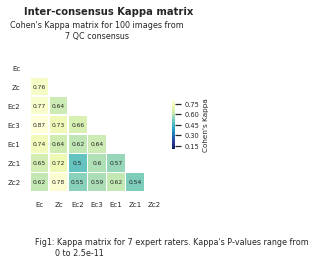

In [17]:
# Plot kappa matrix for expert only
kappa_out = pd.DataFrame(kappa_store, 
                         index=kappa_df.columns.get_values(),
                         columns=kappa_df.columns.get_values())


# Set up the matplotlib figure
f, axes = plt.subplots(figsize = (3,3))
f.subplots_adjust(hspace= .8)
sns.set(font_scale=0.6)
f.suptitle('Inter-consensus Kappa matrix',x=0.49,y=1.05, fontsize=10, fontweight='bold')
# Draw kappa heat map
mask = np.zeros_like(kappa_out)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(kappa_out,vmin=0.1,vmax=0.8,cmap="YlGnBu_r",
            square=True,
            annot=True,annot_kws={"size": 6},
            mask = mask,
            linewidths=.5, 
            cbar_kws={"shrink": .3,"label": "Cohen's Kappa"},  
            ax=axes)
sns.set(style="white")
sns.axes_style("white")

axes.set_yticks([x+0.5 for x in range(len(kappa_df.columns))])
axes.set_yticklabels(kappa_df.columns,rotation=0,fontsize=7)
axes.set_xticklabels(kappa_df.columns,rotation=0,fontsize=7)

text_title = '''
Cohen's Kappa matrix for {} images from
{} QC consensus'''.format(len(cons_df),len(cons_df.columns[1:]))
axes.set_title(text_title,pad=20,fontsize=8)
#axes.annotate('Low', xy=(-0.17, 0.97),xytext=(-0.2, -0), xycoords='axes fraction',
              #arrowprops=dict(arrowstyle="fancy,tail_width=1.2,head_width=01",
                            #fc="0.7", ec="none",
                            #linewidth =2))

# Caption
pval = np.unique(Pval_store)[-1]
txt = '''
    Fig1: Kappa matrix for {} expert raters. Kappa's P-values range from
            {:.2g} to {:.2g} '''.format(len(cons_df.columns[1:]),Pval_store.min(), Pval_store.max())
f.text(0.1,-0.1,txt,fontsize=8);
#f.text(0.11,0.88,'High',fontsize=12)
#f.text(0.10,0.62,'Level of QC expertise',fontsize=12,rotation=90)
# Save figure
f.savefig('../reports/figures/Results/Consensus/Full-Launch-experts_qc.svg')

In [18]:
from IPython.display import Image
Image(url= "https://i.stack.imgur.com/kYNd6.png" ,width=600, height=600)

### Boxplot of kappa distribution between raters

In [19]:
#compute kappa
kappa_df  = cons_df.drop(['ID'],axis=1)
kappa_store, Pval_store = kappa_score(kappa_df)
# Get results into data frame
df_resul= pd.DataFrame(kappa_store,columns=kappa_df.columns,index=kappa_df.columns)
df_resul.head()

,Ec,Zc,Ec2,Ec3,Ec1,Zc1,Zc2
Ec,1.000000,0.758978,0.768744,0.867852,0.736359,0.650602,0.619952
Zc,0.758978,1.000000,0.636150,0.726841,0.642692,0.723158,0.782188
Ec2,0.768744,0.636150,1.000000,0.664751,0.616426,0.500951,0.551105
Ec3,0.867852,0.726841,0.664751,1.000000,0.637024,0.596391,0.589780
Ec1,0.736359,0.642692,0.616426,0.637024,1.000000,0.565416,0.622080


In [20]:
# transform results from matrix like to column like  
df1 = df_resul.stack().reset_index()
#set column names
df1.columns = ['a','b','c']
#remove kappa for between the same rater ( kappa of 1)
df1 = df1[~(df1.a == df1.b)]
df1.head()

,a,b,c
1,Ec,Zc,0.758978
2,Ec,Ec2,0.768744
3,Ec,Ec3,0.867852
4,Ec,Ec1,0.736359
5,Ec,Zc1,0.650602


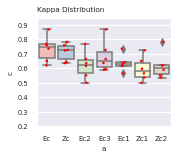

In [22]:
f, axes = plt.subplots(figsize = (2.4,2))
sns.set(style="white")
sns.axes_style("white")
sns.set(font_scale=0.6)
sns.boxplot(x='a', y='c', color="green", data=df1,palette="Pastel1",ax=axes)
sns.stripplot(x='a', y='c', data=df1, color="red", jitter=0.1, size=2.5,ax=axes)
axes.set_xticklabels(df1.a.unique(),rotation=0,fontsize=7)
axes.set_ylim([0.2,0.95])
plt.title("Kappa Distribution", loc="left")
plt.savefig('../reports/figures/Results/Consensus/kappa_distrib.svg')

### Box plot of Kappa between expert and zooniverse consensus

In [23]:
# Get Kappa
kappa_df  = cons_df.drop(['ID'],axis=1)
kappa_store, Pval_store = kappa_score(kappa_df)
# transform results from matrix like to column like  
df= pd.DataFrame(kappa_store,columns=kappa_df.columns,index=kappa_df.columns)
df.head()

,Ec,Zc,Ec2,Ec3,Ec1,Zc1,Zc2
Ec,1.000000,0.758978,0.768744,0.867852,0.736359,0.650602,0.619952
Zc,0.758978,1.000000,0.636150,0.726841,0.642692,0.723158,0.782188
Ec2,0.768744,0.636150,1.000000,0.664751,0.616426,0.500951,0.551105
Ec3,0.867852,0.726841,0.664751,1.000000,0.637024,0.596391,0.589780
Ec1,0.736359,0.642692,0.616426,0.637024,1.000000,0.565416,0.622080


In [24]:
# transform results from matrix like to column like  
df1 = df.stack().reset_index()
#set column names
df1.columns = ['a','b','c']
# slect only Zcon and Econ 
df2 = df1[((df1.b == 'Zc') | (df1.b == 'Ec'))]
# remove kaa between the same rater
df3 = df2[~(df2.a == df2.b)]
# remove econ vs zcon kappa
df4 = df3[~((df1.a == 'Zc') | (df1.a == 'Ec'))]
df4

/mnt/home_sq/yassinebha/.virtualenvs/zooniverse_qc/lib/python3.5/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.


,a,b,c
14,Ec2,Ec,0.768744
15,Ec2,Zc,0.636150
21,Ec3,Ec,0.867852
22,Ec3,Zc,0.726841
28,Ec1,Ec,0.736359
29,Ec1,Zc,0.642692
35,Zc1,Ec,0.650602
36,Zc1,Zc,0.723158
42,Zc2,Ec,0.619952
43,Zc2,Zc,0.782188


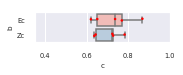

In [25]:
# box plot of zcon econ
f, axes = plt.subplots(figsize = (2.42,0.55))
sns.set(style="white")
sns.axes_style("white")
sns.set(font_scale=0.6)
sns.boxplot(x='c', y='b', color="green", data=df4, palette="Pastel1",ax=axes)
sns.stripplot(x='c', y='b', data=df4, color="red", jitter=0.1, size=2.5,ax=axes)
axes.set_xlim([0.35,1])
#axes.set_xticklabels(df4.b.unique(),rotation=90,fontsize=7)
plt.savefig('../reports/figures/Results/Consensus/expcon_vs_zooncon_distrib.svg')

### Kappa coef Zcon Econ

In [166]:
# Pivot table
df5=df4.pivot_table(values=['c'], index=['a'],columns=['b'])
# flaten hearers and rotate it 
df5.columns = df5.columns.levels[1].get_values()
df5.index.name = None
df5=df5.T
#df5 = df5[['Surc','Jpau','Cmak','Edup','Abad','Atam','Jche','Pfer', 'Czwe']]
df5

,Ec1,Ec2,Ec3,Zc1,Zc2
Ec,0.736359,0.768744,0.867852,0.650602,0.619952
Zc,0.642692,0.636150,0.726841,0.723158,0.782188


In [168]:
econ_ = df5.T.Ec
zcon_ = df5.T.Zc
mean_e = np.mean(econ_)
mean_z = np.mean(zcon_)
std_e = np.std(econ_)
std_z = np.std(zcon_)
max_e = np.max(econ_); min_e = np.min(econ_)
max_z = np.max(zcon_); min_z = np.min(zcon_)
print('Kappa Ec range from {0:.2f} to {1:.2f} ,Mean dice : {2:.2f} , std : {3:.2f}\n'.format(min_e,
                                                                                         max_e,
                                                                                         mean_e,
                                                                                         std_e))
print('Kappa Zc range from {0:.2f} to {1:.2f} ,Mean dice : {2:.2f} , std : {3:.2f}\n'.format(min_z,
                                                                                         max_z,
                                                                                         mean_z,
                                                                                         std_z))

Kappa Ec range from 0.62 to 0.87 ,Mean dice : 0.73 , std : 0.09

Kappa Zc range from 0.64 to 0.78 ,Mean dice : 0.70 , std : 0.06



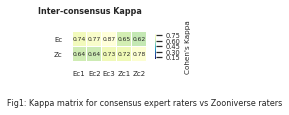

In [169]:
# Plot Dice matrix for concensus exert and  zooniverse

# Set up the matplotlib figure
f, axes = plt.subplots(figsize = (3,0.55))
f.subplots_adjust(hspace= .8)
sns.set(font_scale=0.6)
f.suptitle('Inter-consensus Kappa ',x=0.49,y=1.5, fontsize=8, fontweight='bold')
# Draw kappa heat map

sns.heatmap(df5,vmin=0.1,vmax=0.8,cmap="YlGnBu_r",
            square=True,
            annot=True,annot_kws={"size": 6},
            linewidths=.5, 
            cbar_kws={"shrink": 0.85,"label": "Cohen's Kappa"}, 
            ax=axes)
sns.set(style="white")
sns.axes_style("white")

#axes.set_yticks([x+0.5 for x in range(len(dice_df.columns))])
axes.set_yticklabels(df5.index,rotation=0,fontsize=7)
axes.set_xticklabels(df5.columns,rotation=0,fontsize=7)

# Caption
txt = '''
Fig1: Kappa matrix for consensus expert raters vs Zooniverse raters''';
f.text(0.1,-1,txt,fontsize=8);

# Save figure
f.savefig('../reports/figures/Results/Consensus/experts-Vs-Zooniv.svg')

/mnt/home_sq/yassinebha/.virtualenvs/zooniverse_qc/lib/python3.5/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/mnt/home_sq/yassinebha/.virtualenvs/zooniverse_qc/lib/python3.5/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


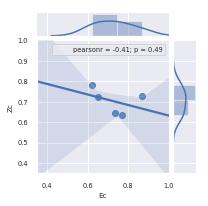

In [170]:
import scipy.stats as stats
sns.set(color_codes=True)
sns.set(font_scale=0.6)
joint = sns.jointplot(x='Ec', y='Zc',data= df5.T,
              kind="reg",xlim=[0.35,1], ylim=[0.35,1])
joint.annotate(stats.pearsonr,)

joint.fig.set_figwidth(2.5)
joint.fig.set_figheight(2.5)
plt.savefig('../reports/figures/Results/Consensus/expert_vs_zooniv_consensus.svg')

### Compute Dice coefficient between raters 

In [171]:
def dice(im1, im2, empty_score=1.0):
    """
    Computes the Dice coefficient, a measure of set similarity.
    Parameters
    ----------
    im1 : array-like, bool
        Any array of arbitrary size. If not boolean, will be converted.
    im2 : array-like, bool
        Any other array of identical size. If not boolean, will be converted.
    Returns
    -------
    dice : float
        Dice coefficient as a float on range [0,1].
        Maximum similarity = 1
        No similarity = 0
        Both are empty (sum eq to zero) = empty_score
        
    Notes
    -----
    The order of inputs for `dice` is irrelevant. The result will be
    identical if `im1` and `im2` are switched.
    """
    im1 = np.asarray(im1).astype(np.bool)
    im2 = np.asarray(im2).astype(np.bool)

    if im1.shape != im2.shape:
        raise ValueError("Shape mismatch: im1 and im2 must have the same shape.")

    im_sum = im1.sum() + im2.sum()
    if im_sum == 0:
        return empty_score

    # Compute Dice coefficient
    intersection = np.logical_and(im1, im2)

    return 2. * intersection.sum() / im_sum

In [172]:
# Dice matrix calculation
from sklearn.preprocessing import OneHotEncoder
def dice_score(d_df):
    '''calculate Dice coefficient between diferent raters organized in dataframe'''
    # initiate a one hot encoder
    onehot_encoder = OneHotEncoder(sparse=False)
    
    scales = np.unique(d_df)
    d_store = np.zeros((len(d_df.columns), len(d_df.columns),len(scales)))
    for ind_scal, scal in enumerate (scales):
        for user1_id, user1 in enumerate(d_df.columns):
            for user2_id, user2 in enumerate(d_df.columns):
                m1 = onehot_encoder.fit_transform(d_df[user1].values.reshape(len(d_df[user1]), 1))[:,ind_scal]
                m2 = onehot_encoder.fit_transform(d_df[user2].values.reshape(len(d_df[user2]), 1))[:,ind_scal]
                d_store[user1_id, user2_id,ind_scal] = dice(m1,m2)
    return d_store,scales

## Dice for OK category

In [173]:
# Get Kappa score out of all different combination of ratings
dice_df  = cons_df.drop(['ID'],axis=1)
dice_store, scales = dice_score(dice_df)

In [177]:
dic_ = dice_store[:,:,0][np.triu_indices(len(dice_store[:,:,0]),k=1)]
mean_dic = np.mean(dic_)
std_dic = np.std(dic_)
max_dic = np.max(dic_)
min_dic = np.min(dic_)
print('Dice OK range from {0:.2f} to {1:.2f} ,Mean dice : {2:.2f} , std : {3:.2f}\n'.format(min_dic,max_dic,mean_dic, std_dic))

Dice OK range from 0.62 to 0.91 ,Mean dice : 0.76 , std : 0.07



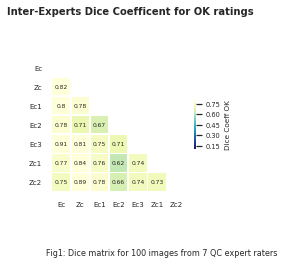

In [178]:
# Plot kappa matrix for expert only
dice_out = pd.DataFrame(dice_store[:,:,0], 
                         index=dice_df.columns.get_values(),
                         columns=dice_df.columns.get_values())


# Set up the matplotlib figure
f, axes = plt.subplots(figsize = (3,3))
f.subplots_adjust(hspace= .8)
sns.set(font_scale=0.6)
f.suptitle('Inter-Experts Dice Coefficent for OK ratings',x=0.49,y=1.05, fontsize=10, fontweight='bold')
# Draw kappa heat map
mask = np.zeros_like(dice_out)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(dice_out,vmin=0.1,vmax=0.8,cmap="YlGnBu_r",
            square=True,
            annot=True,annot_kws={"size": 6},
            mask = mask,
            linewidths=.5, 
            cbar_kws={"shrink": .3,"label": "Dice Coeff OK"}, 
            ax=axes)
sns.set(style="white")
sns.axes_style("white")

axes.set_yticks([x+0.5 for x in range(len(dice_df.columns))])
axes.set_yticklabels(dice_df.columns,rotation=0,fontsize=7)
axes.set_xticklabels(dice_df.columns,rotation=0,fontsize=7)

# Caption
txt = '''
Fig1: Dice matrix for {} images from {} QC expert raters'''.format(len(dice_df),len(dice_df.columns));
f.text(0.1,-0.1,txt,fontsize=8);
#f.text(0.11,0.88,'High',fontsize=12)
#f.text(0.10,0.62,'Level of QC expertise',fontsize=12,rotation=90)
# Save figure
f.savefig('../reports/figures/Results/Consensus/Full-Launch-experts_OK.svg')

### Boxplot of OK Dice distribution between raters

In [179]:
#compute Dice
dice_df  = cons_df.drop(['ID'],axis=1)
dice_store, scales = dice_score(dice_df)
# Get results into data frame
df_resul= pd.DataFrame(dice_store[:,:,0],columns=dice_df.columns,index=dice_df.columns)
df_resul.head()

,Ec,Zc,Ec1,Ec2,Ec3,Zc1,Zc2
Ec,1.000000,0.818182,0.804598,0.782609,0.911392,0.771084,0.747253
Zc,0.818182,1.000000,0.783505,0.708861,0.808989,0.838710,0.891089
Ec1,0.804598,0.783505,1.000000,0.666667,0.750000,0.760870,0.780000
Ec2,0.782609,0.708861,0.666667,1.000000,0.714286,0.621622,0.658537
Ec3,0.911392,0.808989,0.750000,0.714286,1.000000,0.738095,0.739130


In [180]:
# transform results from matrix like to column like  
df1 = df_resul.stack().reset_index()
#set column names
df1.columns = ['a','b','c']
#remove kappa for between the same rater ( kappa of 1)
df1 = df1[~(df1.a == df1.b)]
df1.head()

,a,b,c
1,Ec,Zc,0.818182
2,Ec,Ec1,0.804598
3,Ec,Ec2,0.782609
4,Ec,Ec3,0.911392
5,Ec,Zc1,0.771084


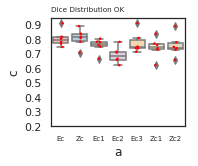

In [181]:
f, axes = plt.subplots(figsize = (2.4,2))
sns.set(style="white")
sns.axes_style("white")
sns.set(font_scale=0.6)
sns.boxplot(x='a', y='c', color="green", data=df1,palette="Pastel1")
sns.stripplot(x='a', y='c', data=df1, color="red", jitter=0.1, size=2.5)
axes.set_xticklabels(df1.a.unique(),rotation=0,fontsize=7)
axes.set_ylim([0.2,0.95])
plt.title("Dice Distribution OK", loc="left")
plt.savefig('../reports/figures/Results/Consensus/expert_distrib_OK.svg')

### Box plot of OK Dice between expert and zooniverse consensus

In [182]:
# Get Dice
dice_df  = cons_df.drop(['ID'],axis=1)
dice_store, scales = dice_score(dice_df)
# transform results from matrix like to column like  
df= pd.DataFrame(dice_store[:,:,0],columns=dice_df.columns,index=dice_df.columns)
df.head()

,Ec,Zc,Ec1,Ec2,Ec3,Zc1,Zc2
Ec,1.000000,0.818182,0.804598,0.782609,0.911392,0.771084,0.747253
Zc,0.818182,1.000000,0.783505,0.708861,0.808989,0.838710,0.891089
Ec1,0.804598,0.783505,1.000000,0.666667,0.750000,0.760870,0.780000
Ec2,0.782609,0.708861,0.666667,1.000000,0.714286,0.621622,0.658537
Ec3,0.911392,0.808989,0.750000,0.714286,1.000000,0.738095,0.739130


In [183]:
# transform results from matrix like to column like  
df1 = df.stack().reset_index()
#set column names
df1.columns = ['a','b','c']
# slect only Zcon and Econ 
df2 = df1[((df1.b == 'Zc') | (df1.b == 'Ec'))]
# remove kaa between the same rater
df3 = df2[~(df2.a == df2.b)]
# remove econ vs zcon kappa
df4 = df3[~((df1.a == 'Zc') | (df1.a == 'Ec'))]
df4

/mnt/home_sq/yassinebha/.virtualenvs/zooniverse_qc/lib/python3.5/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.


,a,b,c
14,Ec1,Ec,0.804598
15,Ec1,Zc,0.783505
21,Ec2,Ec,0.782609
22,Ec2,Zc,0.708861
28,Ec3,Ec,0.911392
29,Ec3,Zc,0.808989
35,Zc1,Ec,0.771084
36,Zc1,Zc,0.838710
42,Zc2,Ec,0.747253
43,Zc2,Zc,0.891089


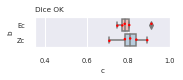

In [184]:
# box plot of zcon econ
f, axes = plt.subplots(figsize = (2.42,0.55))
sns.set(style="white")
sns.axes_style("white")
sns.set(font_scale=0.6)
sns.boxplot(x='c', y='b', color="green", data=df4, palette="Pastel1",ax=axes)
sns.stripplot(x='c', y='b', data=df4, color="red", jitter=0.1, size=2.5,ax=axes)
axes.set_xlim([0.35,1])
plt.title("Dice OK", loc="left")
plt.savefig('../reports/figures/Results/Consensus/expcon_vs_zooncon_OK_distrib.svg')

### Dice coef Zcon Econ OK

In [185]:
# Pivot table
df5=df4.pivot_table(values=['c'], index=['a'],columns=['b'])
# flaten headers and rotate it 
df5.columns = df5.columns.levels[1].get_values()
df5.index.name = None
df5=df5.T
#df5 = df5[['Surc','Jpau','Cmak','Edup','Abad','Atam','Jche','Pfer', 'Czwe']]
df5

,Ec1,Ec2,Ec3,Zc1,Zc2
Ec,0.804598,0.782609,0.911392,0.771084,0.747253
Zc,0.783505,0.708861,0.808989,0.838710,0.891089


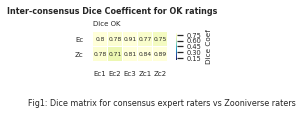

In [186]:
# Plot Dice matrix for concensus exert and  zooniverse

# Set up the matplotlib figure
f, axes = plt.subplots(figsize = (3,0.55))
f.subplots_adjust(hspace= .8)
sns.set(font_scale=0.6)
f.suptitle('Inter-consensus Dice Coefficent for OK ratings',x=0.49,y=1.5, fontsize=8, fontweight='bold')
# Draw kappa heat map
sns.set(font_scale=0.6)
sns.heatmap(df5,vmin=0.1,vmax=0.8,cmap="YlGnBu_r",
            square=True,
            annot=True,annot_kws={"size": 6},
            linewidths=.5, 
            cbar_kws={"shrink": .9,"label": "Dice Coef"}, 
            ax=axes)
sns.set(style="white")
sns.axes_style("white")

#axes.set_yticks([x+0.5 for x in range(len(dice_df.columns))])
axes.set_yticklabels(df5.index,rotation=0,fontsize=7)
axes.set_xticklabels(df5.columns,rotation=0,fontsize=7)

# Caption
txt = '''
Fig1: Dice matrix for consensus expert raters vs Zooniverse raters''';
f.text(0.1,-1,txt,fontsize=8);
plt.title("Dice OK", loc="left",fontsize=7)
# Save figure
f.savefig('../reports/figures/Results/Consensus/Full-Launch-consensus-experts-Vs-Zooniv_OK.svg')

/mnt/home_sq/yassinebha/.virtualenvs/zooniverse_qc/lib/python3.5/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/mnt/home_sq/yassinebha/.virtualenvs/zooniverse_qc/lib/python3.5/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


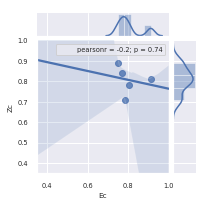

In [187]:
import scipy.stats as stats
sns.set(color_codes=True)
sns.set(font_scale=0.6)
joint = sns.jointplot(x='Ec', y='Zc',data= df5.T,
              kind="reg",xlim=[0.35,1], ylim=[0.35,1])
joint.annotate(stats.pearsonr,)

joint.fig.set_figwidth(2.5)
joint.fig.set_figheight(2.5)
plt.savefig('../reports/figures/Results/Consensus/expert_vs_zooniv_consensus_ok.svg')

## Dice for Maybe category

In [188]:
# Get Kappa score out of all different combination of ratings
dice_df  = cons_df.drop(['ID'],axis=1)
dice_store, scales = dice_score(dice_df)

In [190]:
dic_ = dice_store[:,:,1][np.triu_indices(len(dice_store[:,:,1]),k=1)]
mean_dic = np.mean(dic_)
std_dic = np.std(dic_)
max_dic = np.max(dic_)
min_dic = np.min(dic_)
print('Dice Maybe range from {0:.2f} to {1:.2f} ,Mean dice : {2:.2f} , std : {3:.2f}\n'.format(min_dic,max_dic,mean_dic, std_dic))

Dice Maybe range from 0.47 to 0.88 ,Mean dice : 0.66 , std : 0.11



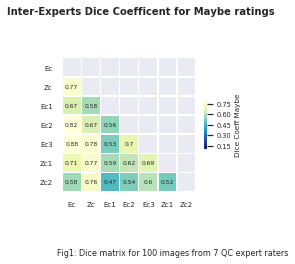

In [191]:
# Plot kappa matrix for expert only
dice_out = pd.DataFrame(dice_store[:,:,1], 
                         index=dice_df.columns.get_values(),
                         columns=dice_df.columns.get_values())


# Set up the matplotlib figure
f, axes = plt.subplots(figsize = (3,3))
f.subplots_adjust(hspace= .8)
sns.set(font_scale=0.6)
f.suptitle('Inter-Experts Dice Coefficent for Maybe ratings',x=0.49,y=1.05, fontsize=10, fontweight='bold')
# Draw kappa heat map
mask = np.zeros_like(dice_out)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(dice_out,vmin=0.1,vmax=0.8,cmap="YlGnBu_r",
            square=True,
            annot=True,annot_kws={"size": 6},
            mask = mask,
            linewidths=.5, 
            cbar_kws={"shrink": .3,"label": "Dice Coeff Maybe"}, 
            ax=axes)
sns.set(style="white")
sns.axes_style("white")

axes.set_yticks([x+0.5 for x in range(len(dice_df.columns))])
axes.set_yticklabels(dice_df.columns,rotation=0,fontsize=7)
axes.set_xticklabels(dice_df.columns,rotation=0,fontsize=7)

# Caption
txt = '''
Fig1: Dice matrix for {} images from {} QC expert raters'''.format(len(dice_df),len(dice_df.columns));
f.text(0.1,-0.1,txt,fontsize=8);
#f.text(0.11,0.88,'High',fontsize=12)
#f.text(0.10,0.62,'Level of QC expertise',fontsize=12,rotation=90)
# Save figure
f.savefig('../reports/figures/Results/Consensus/Full-Launch-experts_Maybe.svg')

### Boxplot of Maybe Dice distribution between raters

In [192]:
#compute Dice
dice_df  = cons_df.drop(['ID'],axis=1)
dice_store, scales = dice_score(dice_df)
# Get results into data frame
df_resul= pd.DataFrame(dice_store[:,:,1],columns=dice_df.columns,index=dice_df.columns)
df_resul.head()

,Ec,Zc,Ec1,Ec2,Ec3,Zc1,Zc2
Ec,1.000000,0.771429,0.666667,0.819277,0.880000,0.712329,0.575758
Zc,0.771429,1.000000,0.581818,0.666667,0.776119,0.769231,0.758621
Ec1,0.666667,0.581818,1.000000,0.558824,0.533333,0.586207,0.470588
Ec2,0.819277,0.666667,0.558824,1.000000,0.700000,0.615385,0.535211
Ec3,0.880000,0.776119,0.533333,0.700000,1.000000,0.685714,0.603175


In [193]:
# transform results from matrix like to column like  
df1 = df_resul.stack().reset_index()
#set column names
df1.columns = ['a','b','c']
#remove kappa for between the same rater ( kappa of 1)
df1 = df1[~(df1.a == df1.b)]
df1.head()

,a,b,c
1,Ec,Zc,0.771429
2,Ec,Ec1,0.666667
3,Ec,Ec2,0.819277
4,Ec,Ec3,0.880000
5,Ec,Zc1,0.712329


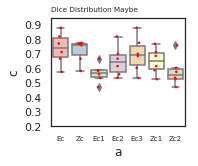

In [194]:
f, axes = plt.subplots(figsize = (2.4,2))
sns.set(style="white")
sns.axes_style("white")
sns.set(font_scale=0.6)
sns.boxplot(x='a', y='c', color="green", data=df1,palette="Pastel1")
sns.stripplot(x='a', y='c', data=df1, color="red", jitter=0.1, size=2.5)
axes.set_xticklabels(df1.a.unique(),rotation=0,fontsize=7)
axes.set_ylim([0.2,0.95])
plt.title("Dice Distribution Maybe", loc="left")
plt.savefig('../reports/figures/Results/Consensus/expert_distrib_Maybe.svg')

### Box plot of Maybe Dice between expert and zooniverse consensus

In [195]:
# Get Dice
dice_df  = cons_df.drop(['ID'],axis=1)
dice_store, scales = dice_score(dice_df)
# transform results from matrix like to column like  
df= pd.DataFrame(dice_store[:,:,1],columns=dice_df.columns,index=dice_df.columns)
df.head()

,Ec,Zc,Ec1,Ec2,Ec3,Zc1,Zc2
Ec,1.000000,0.771429,0.666667,0.819277,0.880000,0.712329,0.575758
Zc,0.771429,1.000000,0.581818,0.666667,0.776119,0.769231,0.758621
Ec1,0.666667,0.581818,1.000000,0.558824,0.533333,0.586207,0.470588
Ec2,0.819277,0.666667,0.558824,1.000000,0.700000,0.615385,0.535211
Ec3,0.880000,0.776119,0.533333,0.700000,1.000000,0.685714,0.603175


In [196]:
# transform results from matrix like to column like  
df1 = df.stack().reset_index()
#set column names
df1.columns = ['a','b','c']
# slect only Zcon and Econ 
df2 = df1[((df1.b == 'Zc') | (df1.b == 'Ec'))]
# remove kaa between the same rater
df3 = df2[~(df2.a == df2.b)]
# remove econ vs zcon kappa
df4 = df3[~((df1.a == 'Zc') | (df1.a == 'Ec'))]
df4

/mnt/home_sq/yassinebha/.virtualenvs/zooniverse_qc/lib/python3.5/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.


,a,b,c
14,Ec1,Ec,0.666667
15,Ec1,Zc,0.581818
21,Ec2,Ec,0.819277
22,Ec2,Zc,0.666667
28,Ec3,Ec,0.880000
29,Ec3,Zc,0.776119
35,Zc1,Ec,0.712329
36,Zc1,Zc,0.769231
42,Zc2,Ec,0.575758
43,Zc2,Zc,0.758621


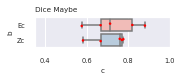

In [197]:
# box plot of zcon econ
f, axes = plt.subplots(figsize = (2.42,0.55))
sns.set(style="white")
sns.axes_style("white")
sns.set(font_scale=0.6)
sns.boxplot(x='c', y='b', color="green", data=df4, palette="Pastel1",ax=axes)
sns.stripplot(x='c', y='b', data=df4, color="red", jitter=0.1, size=2.5,ax=axes)
axes.set_xlim([0.35,1])
plt.title("Dice Maybe", loc="left")
plt.savefig('../reports/figures/Results/Consensus/expcon_vs_zooncon_Maybe_distrib.svg')

### Dice coef Zcon Econ Maybe

In [198]:
# Pivot table
df5=df4.pivot_table(values=['c'], index=['a'],columns=['b'])
# flaten hearers and rotate it 
df5.columns = df5.columns.levels[1].get_values()
df5.index.name = None
df5=df5.T
#df5 = df5[['Surc','Jpau','Cmak','Edup','Abad','Atam','Jche','Pfer', 'Czwe']]
df5

,Ec1,Ec2,Ec3,Zc1,Zc2
Ec,0.666667,0.819277,0.880000,0.712329,0.575758
Zc,0.581818,0.666667,0.776119,0.769231,0.758621


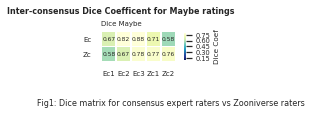

In [199]:
# Plot Dice matrix for concensus exert and  zooniverse

# Set up the matplotlib figure
f, axes = plt.subplots(figsize = (3,0.55))
f.subplots_adjust(hspace= .8)
sns.set(font_scale=0.6)
f.suptitle('Inter-consensus Dice Coefficent for Maybe ratings',x=0.49,y=1.5, fontsize=8, fontweight='bold')
# Draw kappa heat map
sns.set(font_scale=0.6)
sns.heatmap(df5,vmin=0.1,vmax=0.8,cmap="YlGnBu_r",
            square=True,
            annot=True,annot_kws={"size": 6},
            linewidths=.5, 
            cbar_kws={"shrink": .9,"label": "Dice Coef"}, 
            ax=axes)
sns.set(style="white")
sns.axes_style("white")

#axes.set_yticks([x+0.5 for x in range(len(dice_df.columns))])
axes.set_yticklabels(df5.index,rotation=0,fontsize=7)
axes.set_xticklabels(df5.columns,rotation=0,fontsize=7)

# Caption
txt = '''
Fig1: Dice matrix for consensus expert raters vs Zooniverse raters''';
f.text(0.1,-1,txt,fontsize=8);
plt.title("Dice Maybe", loc="left",fontsize=7)
# Save figure
f.savefig('../reports/figures/Results/Consensus/Full-Launch-consensus-experts-Vs-Zooniv_Maybe.svg')

/mnt/home_sq/yassinebha/.virtualenvs/zooniverse_qc/lib/python3.5/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/mnt/home_sq/yassinebha/.virtualenvs/zooniverse_qc/lib/python3.5/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


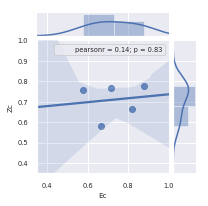

In [200]:
import scipy.stats as stats
sns.set(color_codes=True)
sns.set(font_scale=0.6)
joint = sns.jointplot(x='Ec', y='Zc',data= df5.T,
              kind="reg",xlim=[0.35,1], ylim=[0.35,1])
joint.annotate(stats.pearsonr,)

joint.fig.set_figwidth(2.5)
joint.fig.set_figheight(2.5)
plt.savefig('../reports/figures/Results/Consensus/expert_vs_zooniv_consensus_maybe.svg')

## Dice for Fail category

In [201]:
# Get Kappa score out of all different combination of ratings
dice_df  = cons_df.drop(['ID'],axis=1)
dice_store, scales = dice_score(dice_df)

In [202]:
dic_ = dice_store[:,:,2][np.triu_indices(len(dice_store[:,:,2]),k=1)]
mean_dic = np.mean(dic_)
std_dic = np.std(dic_)
max_dic = np.max(dic_)
min_dic = np.min(dic_)
print('Dice Fail range from {0:.2f} to {1:.2f} ,Mean dice : {2:.2f} , std : {3:.2f}\n'.format(min_dic,max_dic,mean_dic, std_dic))

Dice Fail range from 0.68 to 0.92 ,Mean dice : 0.81 , std : 0.07



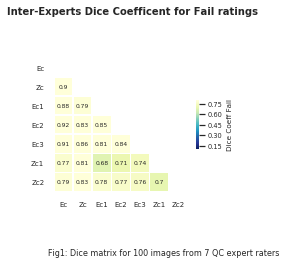

In [126]:
# Plot kappa matrix for expert only
dice_out = pd.DataFrame(dice_store[:,:,2], 
                         index=dice_df.columns.get_values(),
                         columns=dice_df.columns.get_values())


# Set up the matplotlib figure
f, axes = plt.subplots(figsize = (3,3))
f.subplots_adjust(hspace= .8)
sns.set(font_scale=0.6)
f.suptitle('Inter-Experts Dice Coefficent for Fail ratings',x=0.49,y=1.05, fontsize=10, fontweight='bold')
# Draw kappa heat map
mask = np.zeros_like(dice_out)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(dice_out,vmin=0.1,vmax=0.8,cmap="YlGnBu_r",
            square=True,
            annot=True,annot_kws={"size": 6},
            mask = mask,
            linewidths=.5, 
            cbar_kws={"shrink": .3,"label": "Dice Coeff Fail"}, 
            ax=axes)
sns.set(style="white")
sns.axes_style("white")

axes.set_yticks([x+0.5 for x in range(len(dice_df.columns))])
axes.set_yticklabels(dice_df.columns,rotation=0,fontsize=7)
axes.set_xticklabels(dice_df.columns,rotation=0,fontsize=7)

# Caption
txt = '''
Fig1: Dice matrix for {} images from {} QC expert raters'''.format(len(dice_df),len(dice_df.columns));
f.text(0.1,-0.1,txt,fontsize=8);
#f.text(0.11,0.88,'High',fontsize=12)
#f.text(0.10,0.62,'Level of QC expertise',fontsize=12,rotation=90)
# Save figure
f.savefig('../reports/figures/Results/Consensus/Full-Launch-experts_Fail.svg')

### Boxplot of Fail Dice distribution between raters

In [127]:
#compute Dice
dice_df  = cons_df.drop(['ID'],axis=1)
dice_store, scales = dice_score(dice_df)
# Get results into data frame
df_resul= pd.DataFrame(dice_store[:,:,2],columns=dice_df.columns,index=dice_df.columns)
df_resul.head()

,Ec,Zc,Ec1,Ec2,Ec3,Zc1,Zc2
Ec,1.000000,0.904762,0.880000,0.916667,0.913043,0.772727,0.790698
Zc,0.904762,1.000000,0.791667,0.826087,0.863636,0.809524,0.829268
Ec1,0.880000,0.791667,1.000000,0.851852,0.807692,0.680000,0.775510
Ec2,0.916667,0.826087,0.851852,1.000000,0.840000,0.708333,0.765957
Ec3,0.913043,0.863636,0.807692,0.840000,1.000000,0.739130,0.755556


In [128]:
# transform results from matrix like to column like  
df1 = df_resul.stack().reset_index()
#set column names
df1.columns = ['a','b','c']
#remove kappa for between the same rater ( kappa of 1)
df1 = df1[~(df1.a == df1.b)]
df1.head()

,a,b,c
1,Ec,Zc,0.904762
2,Ec,Ec1,0.880000
3,Ec,Ec2,0.916667
4,Ec,Ec3,0.913043
5,Ec,Zc1,0.772727


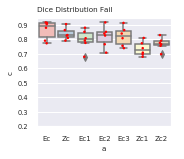

In [130]:
f, axes = plt.subplots(figsize = (2.4,2))
sns.set(style="white")
sns.axes_style("white")
sns.set(font_scale=0.6)
sns.boxplot(x='a', y='c', color="green", data=df1,palette="Pastel1")
sns.stripplot(x='a', y='c', data=df1, color="red", jitter=0.1, size=2.5)
axes.set_xticklabels(df1.a.unique(),rotation=0,fontsize=7)
axes.set_ylim([0.2,0.95])
plt.title("Dice Distribution Fail", loc="left")
plt.savefig('../reports/figures/Results/Consensus/expert_distrib_Fail.svg')

### Box plot of Fail Dice between expert and zooniverse consensus

In [131]:
# Get Dice
dice_df  = cons_df.drop(['ID'],axis=1)
dice_store, scales = dice_score(dice_df)
# transform results from matrix like to column like  
df= pd.DataFrame(dice_store[:,:,2],columns=dice_df.columns,index=dice_df.columns)
df.head()

,Ec,Zc,Ec1,Ec2,Ec3,Zc1,Zc2
Ec,1.000000,0.904762,0.880000,0.916667,0.913043,0.772727,0.790698
Zc,0.904762,1.000000,0.791667,0.826087,0.863636,0.809524,0.829268
Ec1,0.880000,0.791667,1.000000,0.851852,0.807692,0.680000,0.775510
Ec2,0.916667,0.826087,0.851852,1.000000,0.840000,0.708333,0.765957
Ec3,0.913043,0.863636,0.807692,0.840000,1.000000,0.739130,0.755556


In [132]:
# transform results from matrix like to column like  
df1 = df.stack().reset_index()
#set column names
df1.columns = ['a','b','c']
# slect only Zcon and Econ 
df2 = df1[((df1.b == 'Zc') | (df1.b == 'Ec'))]
# remove kaa between the same rater
df3 = df2[~(df2.a == df2.b)]
# remove econ vs zcon kappa
df4 = df3[~((df1.a == 'Zc') | (df1.a == 'Ec'))]
df4

/mnt/home_sq/yassinebha/.virtualenvs/zooniverse_qc/lib/python3.5/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.


,a,b,c
14,Ec1,Ec,0.880000
15,Ec1,Zc,0.791667
21,Ec2,Ec,0.916667
22,Ec2,Zc,0.826087
28,Ec3,Ec,0.913043
29,Ec3,Zc,0.863636
35,Zc1,Ec,0.772727
36,Zc1,Zc,0.809524
42,Zc2,Ec,0.790698
43,Zc2,Zc,0.829268


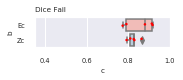

In [133]:
# box plot of zcon econ
f, axes = plt.subplots(figsize = (2.42,0.55))
sns.set(style="white")
sns.axes_style("white")
sns.set(font_scale=0.6)
sns.boxplot(x='c', y='b', color="green", data=df4, palette="Pastel1",ax=axes)
sns.stripplot(x='c', y='b', data=df4, color="red", jitter=0.1, size=2.5,ax=axes)
axes.set_xlim([0.35,1])
plt.title("Dice Fail", loc="left")
plt.savefig('../reports/figures/Results/Consensus/expcon_vs_zooncon_Fail_distrib.svg')

### Dice coef Zcon Econ Fail

In [134]:
# Pivot table
df5=df4.pivot_table(values=['c'], index=['a'],columns=['b'])
# flaten hearers and rotate it 
df5.columns = df5.columns.levels[1].get_values()
df5.index.name = None
df5=df5.T
#df5 = df5[['Surc','Jpau','Cmak','Edup','Abad','Atam','Jche','Pfer', 'Czwe']]
df5

,Ec1,Ec2,Ec3,Zc1,Zc2
Ec,0.880000,0.916667,0.913043,0.772727,0.790698
Zc,0.791667,0.826087,0.863636,0.809524,0.829268


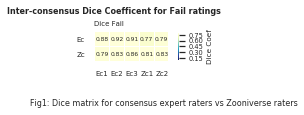

In [135]:
# Plot Dice matrix for concensus exert and  zooniverse

# Set up the matplotlib figure
f, axes = plt.subplots(figsize = (3,0.55))
f.subplots_adjust(hspace= .8)
sns.set(font_scale=0.6)
f.suptitle('Inter-consensus Dice Coefficent for Fail ratings',x=0.49,y=1.5, fontsize=8, fontweight='bold')
# Draw kappa heat map
sns.set(font_scale=0.6)
sns.heatmap(df5,vmin=0.1,vmax=0.8,cmap="YlGnBu_r",
            square=True,
            annot=True,annot_kws={"size": 6},
            linewidths=.5, 
            cbar_kws={"shrink": .9,"label": "Dice Coef"}, 
            ax=axes)
sns.set(style="white")
sns.axes_style("white")

#axes.set_yticks([x+0.5 for x in range(len(dice_df.columns))])
axes.set_yticklabels(df5.index,rotation=0,fontsize=7)
axes.set_xticklabels(df5.columns,rotation=0,fontsize=7)

# Caption
txt = '''
Fig1: Dice matrix for consensus expert raters vs Zooniverse raters''';
f.text(0.1,-1,txt,fontsize=8);
plt.title("Dice Fail", loc="left",fontsize=7)
# Save figure
f.savefig('../reports/figures/Results/Consensus/Full-Launch-consensus-experts-Vs-Zooniv_Fail.svg')

/mnt/home_sq/yassinebha/.virtualenvs/zooniverse_qc/lib/python3.5/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/mnt/home_sq/yassinebha/.virtualenvs/zooniverse_qc/lib/python3.5/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


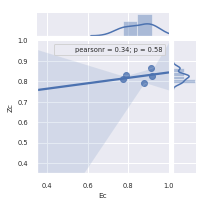

In [136]:
import scipy.stats as stats
sns.set(color_codes=True)
sns.set(font_scale=0.6)
joint = sns.jointplot(x='Ec', y='Zc',data= df5.T,
              kind="reg",xlim=[0.35,1], ylim=[0.35,1])
joint.annotate(stats.pearsonr,)

joint.fig.set_figwidth(2.5)
joint.fig.set_figheight(2.5)
plt.savefig('../reports/figures/Results/Consensus/expert_vs_zooniv_consensus_fail.svg')